In [98]:
import os
import sys
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

# import seaborn as sns
# import yfinance as yf
# import pandas as pd
# import numpy as np
# import sys
# import os

plt.style.use('Solarize_Light2')

In [99]:
TICKERS = ['EURUSD=X', 'USDCHF=X']

def load_data():
    # end_date = '2024-10-16'
    # start_date = pd.to_datetime(end_date)-pd.DateOffset(364*2)

    if os.path.exists("data.csv"):
        _df = pd.read_csv("data.csv")
        _df['Datetime'] = pd.to_datetime(_df['Datetime'], utc=True)
        _df.set_index(['Datetime', 'Ticker'], inplace=True)
    else:
        _df = yf.download(
                tickers=TICKERS, 
                interval='1h', 
                period="max", 
                # start=start_date,
                # end=end_date
            ).dropna().drop(columns=['Volume', 'Adj Close']).stack(future_stack=True)
        _df.to_csv("data.csv")

    _df.columns = _df.columns.str.lower()

    return _df

In [100]:
df = load_data()

# # df = df.unstack()

df.tail(10)

close      high       low      open
Datetime                  Ticker                                          
2024-10-18 17:00:00+00:00 EURUSD=X  1.086484  1.086838  1.086248  1.086838
                          USDCHF=X  0.865530  0.865800  0.865030  0.865080
2024-10-18 18:00:00+00:00 EURUSD=X  1.086838  1.087075  1.086484  1.086484
                          USDCHF=X  0.865330  0.865660  0.865000  0.865550
2024-10-18 19:00:00+00:00 EURUSD=X  1.086720  1.086838  1.086602  1.086838
                          USDCHF=X  0.865130  0.865550  0.865070  0.865320
2024-10-18 20:00:00+00:00 EURUSD=X  1.087075  1.087311  1.086602  1.086602
                          USDCHF=X  0.864670  0.865280  0.864410  0.865140
2024-10-18 21:00:00+00:00 EURUSD=X  1.086957  1.086957  1.086957  1.086957
                          USDCHF=X  0.863900  0.864500  0.863900  0.864500

In [101]:
# bool_df = df.isna()

# truth_df = bool_df.loc[
#           (bool_df['close'][TICKERS[0]] == True) | (bool_df['close'][TICKERS[1]] == True)
#         | (bool_df['high'][TICKERS[0]] == True) | (bool_df['high'][TICKERS[1]] == True)
#         | (bool_df['low'][TICKERS[0]] == True) | (bool_df['low'][TICKERS[1]] == True)
#         | (bool_df['open'][TICKERS[0]] == True) | (bool_df['open'][TICKERS[1]] == True)
#     ]

# if not truth_df.empty:
#     print("There is missing data")
#     sys.exit("There is missing data")

# df.dropna(inplace=True)

In [102]:
df_pct_change = df.groupby(level=1).pct_change().dropna()

# for idx, row in df_pct_change.iterrows():
#     print(idx)

display(df_pct_change.xs(TICKERS[0], level=1).tail())
display(df_pct_change.xs(TICKERS[1], level=1).tail())

,close,high,low,open
Datetime,,,,
2024-10-18 17:00:00+00:00,-0.000435,-0.000217,0.000652,0.001087
2024-10-18 18:00:00+00:00,0.000326,0.000217,0.000217,-0.000326
2024-10-18 19:00:00+00:00,-0.000109,-0.000217,0.000109,0.000326
2024-10-18 20:00:00+00:00,0.000326,0.000435,0.000000,-0.000217
2024-10-18 21:00:00+00:00,-0.000109,-0.000326,0.000326,0.000326


,close,high,low,open
Datetime,,,,
2024-10-18 17:00:00+00:00,0.000520,-0.000266,0.000081,-0.000970
2024-10-18 18:00:00+00:00,-0.000231,-0.000162,-0.000035,0.000543
2024-10-18 19:00:00+00:00,-0.000231,-0.000127,0.000081,-0.000266
2024-10-18 20:00:00+00:00,-0.000532,-0.000312,-0.000763,-0.000208
2024-10-18 21:00:00+00:00,-0.000890,-0.000901,-0.000590,-0.000740


In [103]:
shape_df = {}

for ticker in TICKERS:
    shape_df[ticker] = df_pct_change.xs(ticker, level=1)['close']

pair_close_prx_df = pd.DataFrame(shape_df).dropna()

pair_close_prx_df.tail()

,EURUSD=X,USDCHF=X
Datetime,,
2024-10-18 17:00:00+00:00,-0.000435,0.000520
2024-10-18 18:00:00+00:00,0.000326,-0.000231
2024-10-18 19:00:00+00:00,-0.000109,-0.000231
2024-10-18 20:00:00+00:00,0.000326,-0.000532
2024-10-18 21:00:00+00:00,-0.000109,-0.000890


- **Correlation**

In [117]:
pair_close_prx_df['correlation'] = pair_close_prx_df[TICKERS[0]].rolling(window=51).corr(pair_close_prx_df[TICKERS[1]])
pair_close_prx_df['correlation'] = pair_close_prx_df['correlation'].shift(1)
pair_close_prx_df['pair ratio'] = pair_close_prx_df[TICKERS[0]] / pair_close_prx_df[TICKERS[1]]

pair_close_prx_df.dropna(inplace=True)

pair_close_prx_df.head()

,EURUSD=X,USDCHF=X,correlation,pair ratio
Datetime,,,,
2022-11-30 05:00:00+00:00,-0.000518,0.000840,-0.795811,-0.615967
2022-11-30 06:00:00+00:00,-0.000621,0.001239,-0.798746,-0.501160
2022-11-30 07:00:00+00:00,0.000828,-0.001593,-0.798409,-0.519889
2022-11-30 08:00:00+00:00,0.001659,-0.001722,-0.796302,-0.963684
2022-11-30 09:00:00+00:00,-0.000933,-0.000557,-0.801685,1.672929


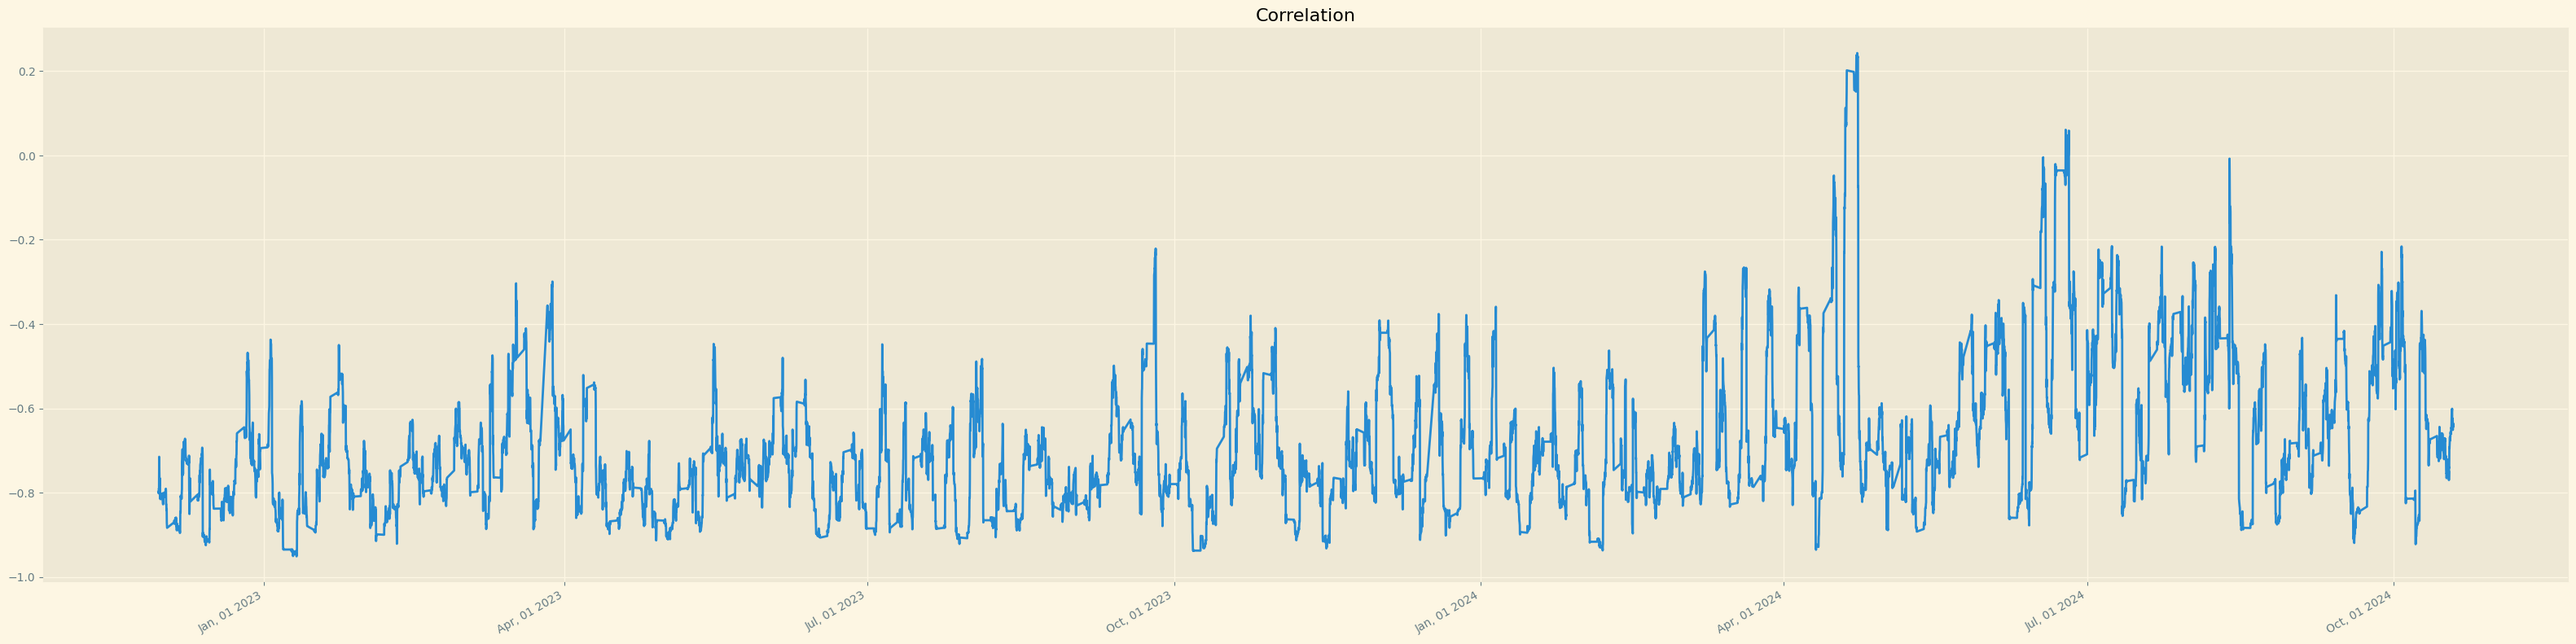

In [118]:
pair_close_prx_df['correlation'].plot(figsize=(40, 10), xlabel='')

plt.title('Correlation')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)

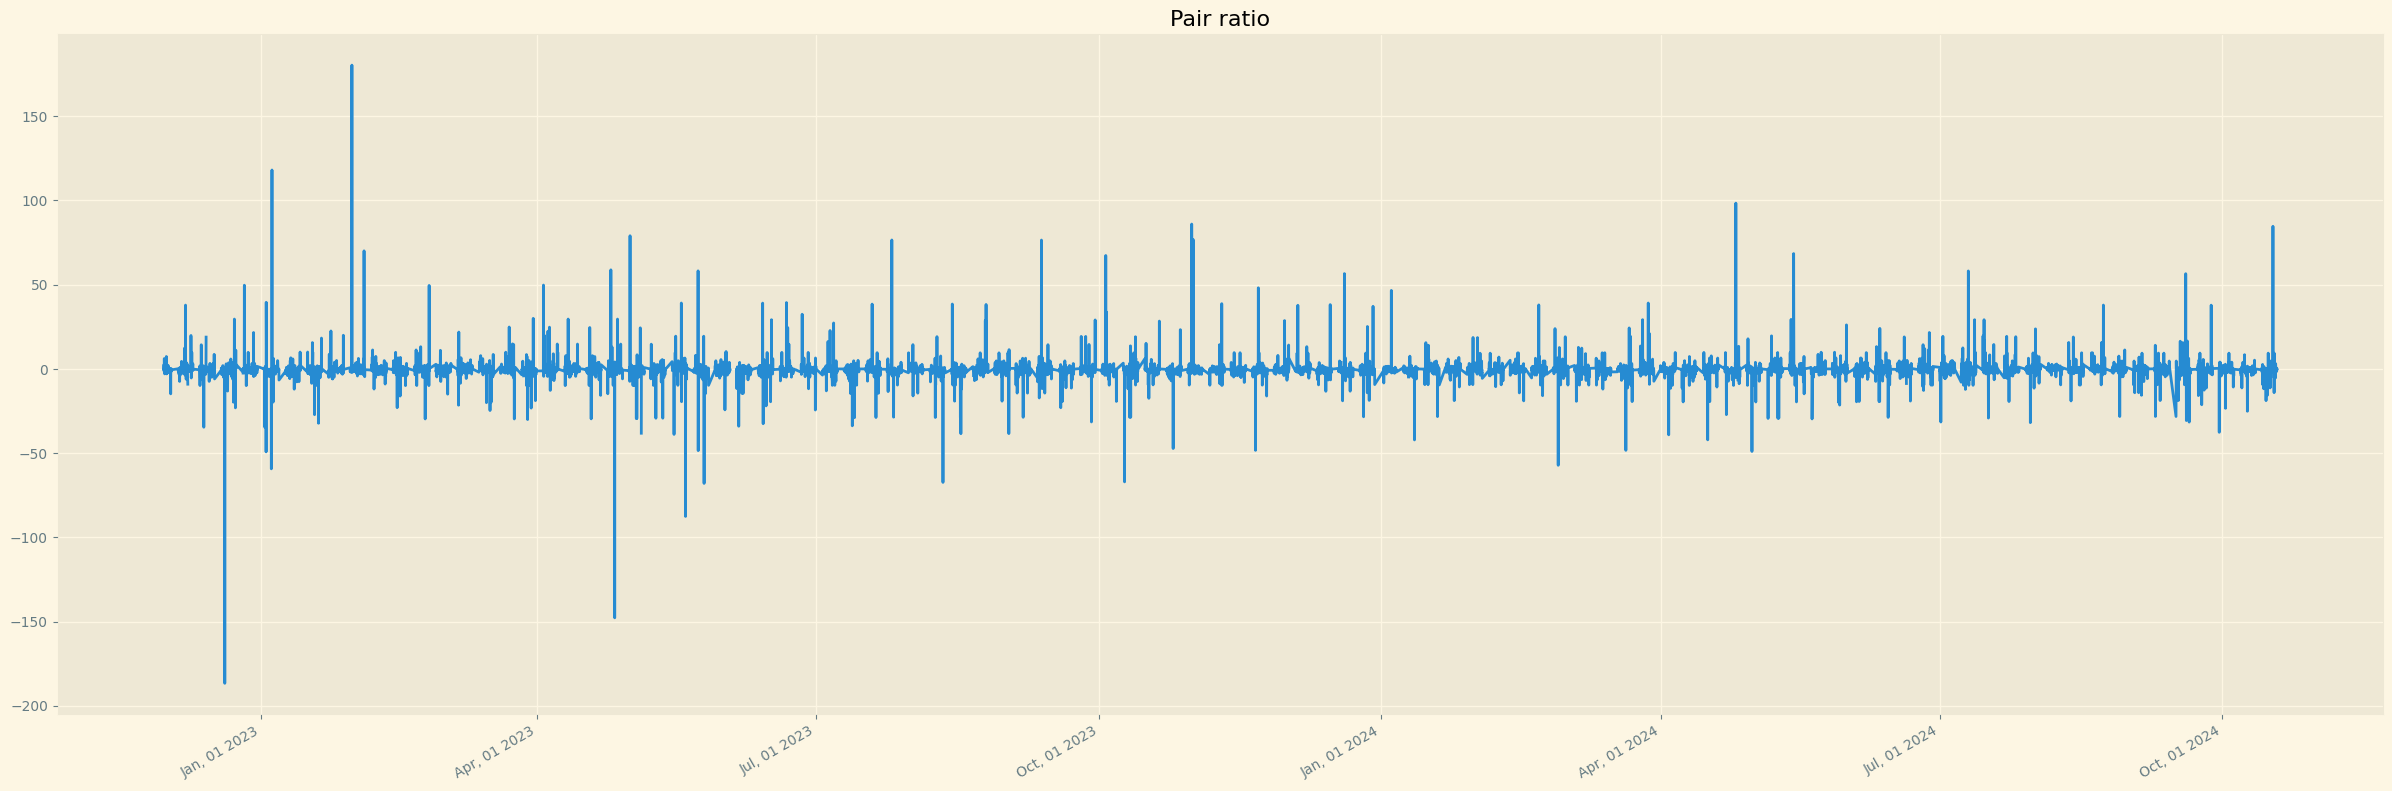

In [119]:
pair_close_prx_df['pair ratio'].plot(figsize=(30, 10), xlabel='')

plt.title('Pair ratio')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter("%b, %d %Y")
plt.gca().xaxis.set_major_formatter(date_format)